In [1]:
import tensorflow as tf
import numpy.random as rnd
import numpy as np

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
reset_graph()

#CONSTRUCTION PHASE
n_steps = 14
n_inputs = 1 
n_neurons = 100
n_outputs = 1
n_layers = 2

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

#y has the same shape
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#create the cells and the layers of the network
layers = [tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),output_size=n_outputs) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers, state_is_tuple=True)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell,X,dtype=tf.float32)

#define the cost function and optimization
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

#Adds an op to initialize all variables in the model
init = tf.global_variables_initializer()

(798,)
(798,)


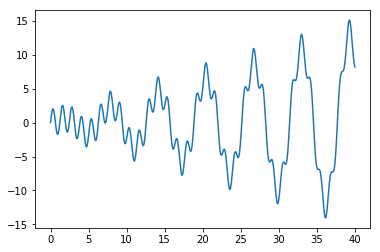

In [5]:
#Import training data
import numpy as np
import random

#Let's create some predictable data!
#X_test = np.arange(0, 81, 1/0.1).astype(int)
x = np.linspace(0, 40, int((80)/0.1))

#X_test = np.linspace(12.2, 12.2 + (n_steps + 1), n_steps + 1)
plt.plot(x, (((x * np.sin(x)) / 3) + (2 * np.sin(x*5))))

X_test = (((x * np.sin(x)) / 3) + (2 * np.sin(x*5)))
#X_test = (X_test * 2).astype(int)
#plt.plot(X_test)
Y_test = X_test[1:]
X_test = X_test[:-2] #strip out last 2 from X_test
Y_test = Y_test[:-1] #strip out last 1 from Y_test 

#print("X_test",X_test)
#print("Y_test", Y_test)
print(X_test.shape)
print(Y_test.shape)
Y_test = Y_test.reshape((-1, n_steps, n_inputs))
X_test = X_test.reshape((-1, n_steps, n_inputs))

In [6]:
#TRAINING PHASE
import tensorflow as tf
import numpy

n_epochs = 500
batch_size = 50
instances = X_test.shape[0]
saver = tf.train.Saver()

print("RNN construction", "n_layers", n_layers, "n_neurons", n_neurons, "n_inputs", n_inputs, "n_outputs", n_outputs)
print("training dataset", "shape", X_test.shape, "instances", instances, "batch_size", batch_size)
print("training with", "n_epochs", n_epochs, "iterations (instances // batch_size)", (instances//batch_size))

#open a TensorFlow Session
with tf.Session() as sess:
    init.run()
    
    #Epoch is a single pass through the entire training set, followed by testing of the verification set.
    for epoch in range(n_epochs):
    
        #print("X_test",X_test)
        idxs = numpy.random.permutation(instances) #shuffled ordering
        X_random = X_test[idxs]
        Y_random = Y_test[idxs]
    
        #Number of batches, here we exhaust the training set
        for iteration in range(instances // batch_size):   

            #get the next batch - we permute the examples in each batch
            X_batch = X_random[iteration * batch_size:(iteration+1) * batch_size]
            y_batch = Y_random[(iteration * batch_size):((iteration+1) * batch_size)]
                        
            X_batch = X_batch.reshape((-1, n_steps, 1))
            y_batch = y_batch.reshape((-1, n_steps, 1))
        
            #feed in the batch
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
            if (epoch % 100 == 0 and iteration == 0):
                #check contents of first example in each batch
                #print("iteration", iteration, "X_batch", X_batch[0])
                #print("iteration", iteration, "y_batch", y_batch[0])
                mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
                print("epoch", epoch, "iteration", iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_model") 

RNN construction n_layers 2 n_neurons 100 n_inputs 1 n_outputs 1
training dataset shape (57, 14, 1) instances 57 batch_size 50
training with n_epochs 500 iterations (instances // batch_size) 1
epoch 0 iteration 0 	MSE: 27.3453
epoch 100 iteration 0 	MSE: 1.11096
epoch 200 iteration 0 	MSE: 0.105353
epoch 300 iteration 0 	MSE: 0.0304361
epoch 400 iteration 0 	MSE: 0.0247568


In [7]:
#Sequence generation using the model
with tf.Session() as sess:                        
    saver.restore(sess, "./my_model") 

    sequence = [0] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_model


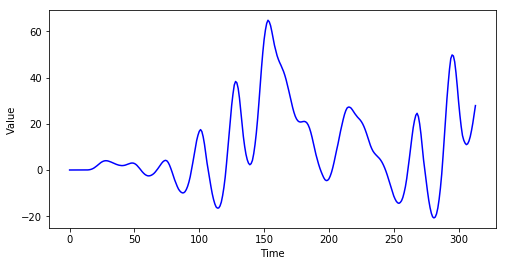

In [8]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(x[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()